# Classifying elliptic curves by complex multiplication

In [1]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from tqdm.notebook import *
from livelossplot import PlotLosses
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("output/dataset.csv")

In [3]:
df.head()

,A2,A3,A5,A7,A11,A13,A17,A19,A23,A29,...,A9901,A9907,A9923,A9929,A9931,A9941,A9949,A9967,A9973,CM
0,0.000000,0.577350,0.000000,0.000000,0.000000,-0.27735,0.000000,0.917663,1.668115,1.114172,...,0.532643,0.934355,0.331278,-0.541927,1.264370,-1.384089,-0.421075,-1.302150,-1.862516,0.0
1,0.707107,0.000000,0.447214,1.511858,0.000000,-1.10940,1.455214,-0.688247,-0.208514,0.000000,...,1.507481,1.547211,-1.264879,0.311106,1.314543,0.702074,1.584044,0.220364,1.361840,0.0
2,-0.707107,0.000000,-0.447214,0.000000,1.206045,-1.10940,-1.455214,0.458831,0.000000,1.856953,...,-1.286383,-0.874074,0.301162,-1.384925,-0.200694,0.140415,-1.142918,-0.030050,0.961299,0.0
3,0.000000,-1.154701,0.000000,-1.511858,-0.904534,0.55470,0.000000,0.458831,1.251086,-1.671258,...,-0.311546,1.587399,-1.415460,1.384925,-0.762636,-0.300889,1.193046,1.041720,-1.061434,0.0
4,-1.414214,0.000000,0.000000,1.133893,0.000000,-0.55470,0.727607,0.917663,0.000000,-0.928477,...,-0.693441,-0.170796,0.582246,0.511820,0.070243,-0.742193,1.162969,0.130215,1.061434,0.0


In [4]:
X = np.array(df)
X = np.delete(X, len(X[0])-1, 1)
Y = np.array(df["CM"])

In [5]:
X.shape

(5000, 1229)

In [6]:
Y.shape

(5000,)

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, shuffle = True)

In [8]:
def ma_sampling(x: list, win = 28): # For pretty plots
    assert len(x)>win, "Window too large!"
    cur_sum = sum(x[:win])
    cur_pos = win - 1
    sampled = []
    for i in range(len(x)-win):
        sampled.append(cur_sum/win)
        cur_sum -= x[cur_pos-win]
        cur_pos += 1
        cur_sum += x[cur_pos]
    return sampled

In [9]:
def acc(X,Y):
    err_cnt = 0
    correct_cnt = 0
    for i in range(len(X)):
        x = torch.tensor(X[i], dtype=torch.double).float()
        y = Y[i]
        _y = model(x)
        if _y[0] > _y[1]:
            cls = 0
        else:
            cls = 1
        if round(y) != cls:
            err_cnt+=1
        else:
            correct_cnt+=1
    return correct_cnt/(correct_cnt+err_cnt)

## Neural network model

In [10]:
DATA_SIZE = len(X[0])
N_EPOCHS = 2000
N_DISPLAY = 20
SAMPLE_SIZE = 100
A=314
k=4
model = nn.Sequential(
        nn.Linear(DATA_SIZE, A),
        nn.Dropout(0.1),
        nn.Tanh(),
        nn.Linear(A, k*A),
        nn.LeakyReLU(),
        nn.Linear(k*A, k*A),
        nn.ELU(),
        nn.Linear(k*A, k*A),
        nn.LeakyReLU(),
        nn.Linear(k*A, A),
        nn.Tanh(),
        nn.Linear(A, 2),
        nn.Softmax()
)
criterion = nn.CrossEntropyLoss() # The MOST inconvinient criterion ever!
optimizer = optim.SGD(model.parameters(), lr=0.01)
print("Untrained accuracy(test): %.3f"%acc(X_test, Y_test))
print("Untrained accuracy(train): %.3f"%acc(X_train, Y_train))

/usr/local/lib/python3.9/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Untrained accuracy(test): 0.509
Untrained accuracy(train): 0.518


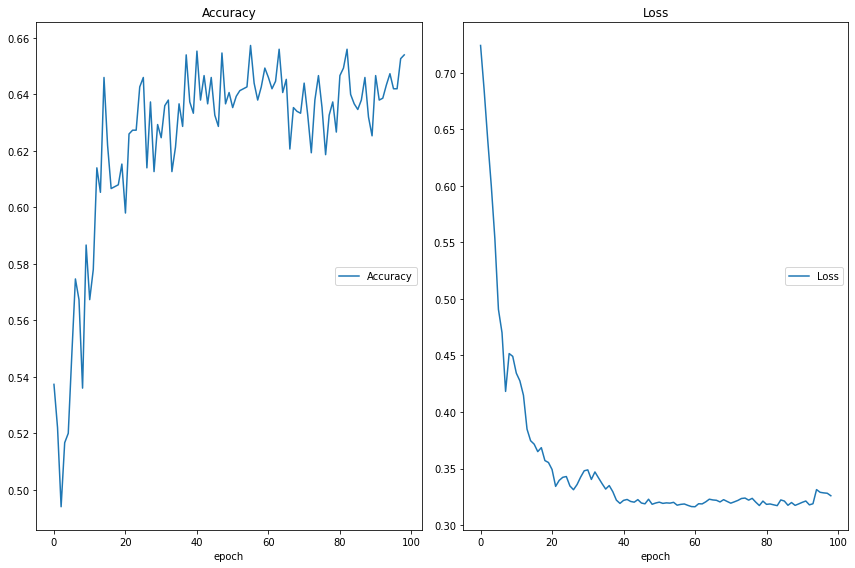

Accuracy
	Accuracy         	 (min:    0.494, max:    0.657, cur:    0.654)
Loss
	Loss             	 (min:    0.316, max:    0.724, cur:    0.326)


In [11]:
losses = []
plotlosses = PlotLosses()
avg_loss_lr = 0.0
avg_accuracy = 0.0
for i in tnrange(N_EPOCHS):
    indices = np.random.choice(X_train.shape[0], SAMPLE_SIZE, replace=False)
    sample_x = X_train[indices]
    sample_y = Y_train[indices]
    avg_loss = 0.0
    for j in range(SAMPLE_SIZE):
        x = torch.Tensor(sample_x[j])
        target = torch.Tensor([int(sample_y[j])]).type(torch.LongTensor)
        optimizer.zero_grad()   
        output = model(x)
        output = output.reshape((1,2)).float()
        loss = criterion(output, target)
        avg_loss += float(loss)
        loss.backward()
        optimizer.step()
    avg_loss /= SAMPLE_SIZE
    avg_loss_lr += avg_loss
    #avg_accuracy += acc(X_test, Y_test)
    if i % N_DISPLAY == 0 and i > 0:
        avg_loss_lr /= N_DISPLAY
        #avg_accuracy /= N_DISPLAY
        plotlosses.update({"Loss": avg_loss_lr, "Accuracy": acc(X_test, Y_test)})
        plotlosses.send()
        avg_loss_lr = 0.0
        avg_accuracy = 0.0
    losses.append(avg_loss)

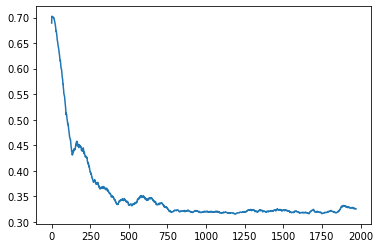

In [12]:
plt.plot(ma_sampling(losses))
plt.show()

In [13]:
print("Acc(train): %.3f"%acc(X_train, Y_train))
print("Acc(test): %.3f"%acc(X_test, Y_test))

Acc(train): 0.989
Acc(test): 0.635


As it can be seen neural networks are absolutely useless for classifying _~~anything~~_ elliptic curves.

## Naive Bayesian classifier

In [14]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
naive_bayes = GaussianNB()
naive_bayes.fit(X_train , Y_train)
Y_predicted = naive_bayes.predict(X_test)
print("Acc: %.3f" % metrics.accuracy_score(Y_predicted , Y_test))

Acc: 0.969


## Convolutional neural network

In [41]:
model = nn.Sequential(
        nn.Conv1d(1, 1, 64),
        nn.MaxPool1d(8),
        nn.LeakyReLU(),
        nn.Linear(145,290),
        nn.Tanh(),
        nn.Linear(290,145),
        nn.LeakyReLU(),
        nn.Linear(145,2)
)

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [43]:
def acc(X,Y):
    err_cnt = 0
    correct_cnt = 0
    for i in range(len(X)):
        x = torch.tensor(X[i], dtype=torch.double).float().reshape((1,1,1229))
        y = Y[i]
        _y = model(x)
        if _y[0][0][0] > _y[0][0][1]:
            cls = 0
        else:
            cls = 1
        if round(y) != cls:
            err_cnt+=1
        else:
            correct_cnt+=1
    return correct_cnt/(correct_cnt+err_cnt)

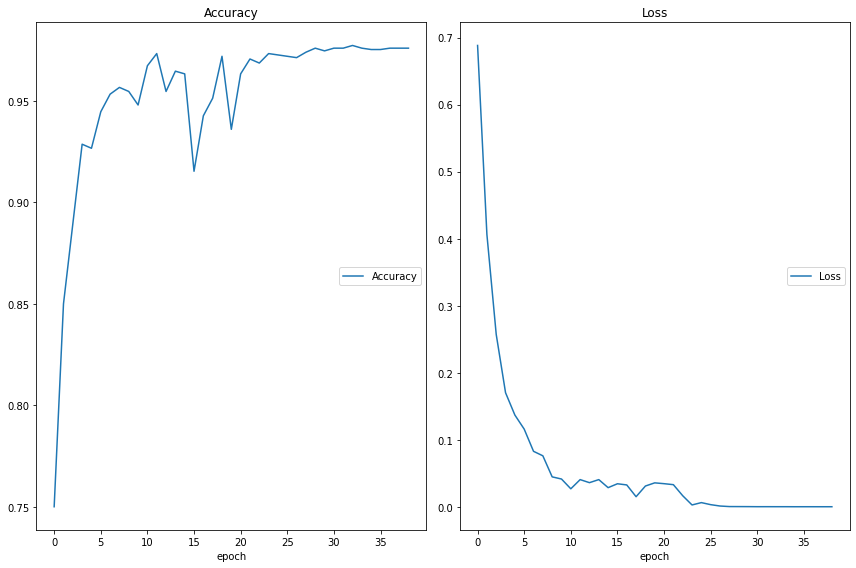

Accuracy
	Accuracy         	 (min:    0.750, max:    0.977, cur:    0.976)
Loss
	Loss             	 (min:    0.000, max:    0.688, cur:    0.000)


In [44]:
DATA_SIZE = len(X[0])
N_EPOCHS = 800
N_DISPLAY = 20
SAMPLE_SIZE = 100
losses = []
plotlosses = PlotLosses()
avg_loss_lr = 0.0
avg_accuracy = 0.0
for i in tnrange(N_EPOCHS):
    indices = np.random.choice(X_train.shape[0], SAMPLE_SIZE, replace=False)
    sample_x = X_train[indices]
    sample_y = Y_train[indices]
    avg_loss = 0.0
    for j in range(SAMPLE_SIZE):
        x = torch.Tensor(sample_x[j]).reshape((1,1,1229))
        target = torch.Tensor([int(sample_y[j])]).type(torch.LongTensor)
        optimizer.zero_grad()   
        output = model(x)
        output = output[0]
        loss = criterion(output, target)
        avg_loss += float(loss)
        loss.backward()
        optimizer.step()
    avg_loss /= SAMPLE_SIZE
    avg_loss_lr += avg_loss
    #avg_accuracy += acc(X_test, Y_test)
    if i % N_DISPLAY == 0 and i > 0:
        avg_loss_lr /= N_DISPLAY
        #avg_accuracy /= N_DISPLAY
        plotlosses.update({"Loss": avg_loss_lr, "Accuracy": acc(X_test, Y_test)})
        plotlosses.send()
        avg_loss_lr = 0.0
        avg_accuracy = 0.0
    losses.append(avg_loss)

In [35]:
print("Acc: %.3f" % acc(X_test, Y_test)) 

Acc: 0.975


Is this magic of random intialization?...or convolutional networks really suitable for working with big vectors? Anyway, lets save this network:

In [36]:
torch.save(model, "output/magic.th")